In [1]:
from pulp import *


In [2]:
#Initialize the model
model = pulp.LpProblem("Maximize-Profit", LpMaximize)

In [3]:
# Selling Prices per box
Selling_Prices = {
    'GT50': 6, 'GT100': 10, 'BT50': 7, 'BT100': 12,
    'WT50': 9, 'WT100': 16, 'RT50': 8, 'RT100': 14
}

# Buying Prices per 100g
Buying_Prices = {'GT': 3.5, 'BT': 4.5, 'WT': 5.5, 'RT': 5.0}

#Types of Tea 
Teas = ['GT', 'BT', 'WT', 'RT']
#Packaging sizes
Sizes = [50, 100]
#Countries that we will be shipping the Tea to
Countries = ['Portugal', 'Spain', 'France', 'Italy', 'Germany', 'Poland']

# Distribution costs per box
Distribution_Costs = {
    'Portugal': 0.5, 'Spain': 0.4, 'France': 0.6,
    'Italy': 0.7, 'Germany': 0.8, 'Poland': 1.0
}

In [4]:
Demand_Forecast = {
    ('Portugal', 'GT50'): 100, ('Portugal', 'GT100'): 80,
    ('Portugal', 'BT50'): 90,  ('Portugal', 'BT100'): 70,
    ('Portugal', 'WT50'): 50,  ('Portugal', 'WT100'): 40,
    ('Portugal', 'RT50'): 60,  ('Portugal', 'RT100'): 50,
    ('Spain', 'GT50'): 150,    ('Spain', 'GT100'): 120,
    ('Spain', 'BT50'): 130,    ('Spain', 'BT100'): 110,
    ('Spain', 'WT50'): 80,     ('Spain', 'WT100'): 60,
    ('Spain', 'RT50'): 100,    ('Spain', 'RT100'): 90,
    ('France', 'GT50'): 200,   ('France', 'GT100'): 170,
    ('France', 'BT50'): 180,   ('France', 'BT100'): 160,
    ('France', 'WT50'): 100,   ('France', 'WT100'): 90,
    ('France', 'RT50'): 120,   ('France', 'RT100'): 110,
    ('Italy', 'GT50'): 130,    ('Italy', 'GT100'): 110,
    ('Italy', 'BT50'): 120,    ('Italy', 'BT100'): 100,
    ('Italy', 'WT50'): 70,     ('Italy', 'WT100'): 60,
    ('Italy', 'RT50'): 90,     ('Italy', 'RT100'): 80,
    ('Germany', 'GT50'): 180,  ('Germany', 'GT100'): 160,
    ('Germany', 'BT50'): 170,  ('Germany', 'BT100'): 150,
    ('Germany', 'WT50'): 90,   ('Germany', 'WT100'): 80,
    ('Germany', 'RT50'): 110,  ('Germany', 'RT100'): 100,
    ('Poland', 'GT50'): 120,   ('Poland', 'GT100'): 100,
    ('Poland', 'BT50'): 110,   ('Poland', 'BT100'): 90,
    ('Poland', 'WT50'): 60,    ('Poland', 'WT100'): 50,
    ('Poland', 'RT50'): 80,    ('Poland', 'RT100'): 70
}

In [5]:
#fixed costs
marketing_cost = 400000
fixed_annual_cost = 4000000
total_annual_cost = marketing_cost + fixed_annual_cost
production_cost_per_box = 1

#constants
max_production = 2000000

#Raw Tea Availability
Raw_Tea_Availability = {
    'GT': 25000000, 'BT': 30000000,
    'WT': 15000000, 'RT': 20000000
}

In [6]:
# Define the decision variables, but we use the LpVariable.dicts() method to create a dictionary of decision variables as opposed to creating each one individually. It is due to the fact that we have 48 of them as 2 sizes * 4 types * 6 countries.
variables = LpVariable.dicts("Tea_Boxes", [(t, s, c) for t in Teas for s in Sizes for c in Countries], lowBound=0, cat='Integer')

In [7]:
# Find Revenue that will be used in objective function later as in lab 1 4.5 * Beer + 5 * Wine but we don't have to write it all down as we have a dictionary of selling prices.
Revenue = lpSum([Selling_Prices[f"{t}{s}"] * variables[(t, s, c)] for t in Teas for s in Sizes for c in Countries])

#costs ber pox for each type of tea and size, similarly as above we have a dictionary of buying prices and distribution costs for each country. 48 different costs.
Variable_Costs = {}
for t in Teas: #iterate through the types of tea
    for s in Sizes: #iterate through the sizes
        size_factor = s / 100  
        buying_cost = Buying_Prices[t] * size_factor 
        for c in Countries:
            total_var_cost = buying_cost + production_cost_per_box + Distribution_Costs[c]
            Variable_Costs[(t, s, c)] = total_var_cost

# Find the total variable cost (simply multiply the decision variables by the variable costs and sum them up)

Total_Variable_Cost = pulp.lpSum(
    Variable_Costs[(t, s, c)] * variables[(t, s, c)]
    for t in Teas for s in Sizes for c in Countries
)


Model with all constraints such as max amount of boxes , raw tea availability, minimum production constraints and minimum demand for each type of tea and size

In [8]:
model += Revenue - Total_Variable_Cost - total_annual_cost

#production constraints however, it doesn't matter as we have 90mln gram of raw tea and if we all pack them to 50g boxes it will only be 1.8mln boxes
model += pulp.lpSum(
    variables[(t, s, c)] for t in Teas for s in Sizes for c in Countries
) <= 2000000, "Production_Capacity"

#Raw Tea Availability constraints
for t in Teas:
    model += pulp.lpSum(
        variables[(t, s, c)] * s  
        for s in Sizes for c in Countries
    ) <= Raw_Tea_Availability[t], f"Raw_Tea_{t}"

#minimum production constraints for each type of tea
total_boxes = pulp.lpSum(
    variables[(t, s, c)] for t in Teas for s in Sizes for c in Countries
)

for t in Teas:
    model += pulp.lpSum(
        variables[(t, s, c)] for s in Sizes for c in Countries
    ) >= 0.1 * total_boxes, "Minimum_Production_" + t

# Demand constraints
for t in Teas:
    for s in Sizes:
        for c in Countries:
            demand = Demand_Forecast.get((c, f"{t}{s}"), 0)
            model += variables[(t, s, c)] >= demand, f"MinDemand_{t}_{s}_{c}"

# Solve the model
model.solve()

1

In [9]:
print("Status:", LpStatus[model.status])

for v in model.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)

print("Total Profit (including fixed costs) = $", pulp.value(model.objective))


Status: Optimal
Tea_Boxes_('BT',_100,_'France') = 160.0
Tea_Boxes_('BT',_100,_'Germany') = 150.0
Tea_Boxes_('BT',_100,_'Italy') = 100.0
Tea_Boxes_('BT',_100,_'Poland') = 90.0
Tea_Boxes_('BT',_100,_'Portugal') = 70.0
Tea_Boxes_('BT',_100,_'Spain') = 110.0
Tea_Boxes_('BT',_50,_'France') = 180.0
Tea_Boxes_('BT',_50,_'Germany') = 170.0
Tea_Boxes_('BT',_50,_'Italy') = 120.0
Tea_Boxes_('BT',_50,_'Poland') = 110.0
Tea_Boxes_('BT',_50,_'Portugal') = 90.0
Tea_Boxes_('BT',_50,_'Spain') = 597970.0
Tea_Boxes_('GT',_100,_'France') = 170.0
Tea_Boxes_('GT',_100,_'Germany') = 160.0
Tea_Boxes_('GT',_100,_'Italy') = 110.0
Tea_Boxes_('GT',_100,_'Poland') = 100.0
Tea_Boxes_('GT',_100,_'Portugal') = 80.0
Tea_Boxes_('GT',_100,_'Spain') = 120.0
Tea_Boxes_('GT',_50,_'France') = 200.0
Tea_Boxes_('GT',_50,_'Germany') = 180.0
Tea_Boxes_('GT',_50,_'Italy') = 130.0
Tea_Boxes_('GT',_50,_'Poland') = 120.0
Tea_Boxes_('GT',_50,_'Portugal') = 100.0
Tea_Boxes_('GT',_50,_'Spain') = 497790.0
Tea_Boxes_('RT',_100,_'France'

All of the below is out of picture but wanted to show that after reading the task my first idea was that it's all going to go to Spain after fulfilling the demand as it has the smallest transportation cost

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import LpStatus


In [11]:
import re

data = []

for v in model.variables():
    if v.varValue > 0:
        var_name = v.name
        var_value = v.varValue

        match = re.match(r"Tea_Boxes_\('(\w+)',_(\d+),_'(\w+)'\)", var_name)
        if match:
            tea = match.group(1)
            size = match.group(2)
            country = match.group(3)
            data.append({'Tea': tea, 'Size': size, 'Country': country, 'Value': var_value})
        else:
            print(f"Unexpected variable name format: {var_name}")

df = pd.DataFrame(data)


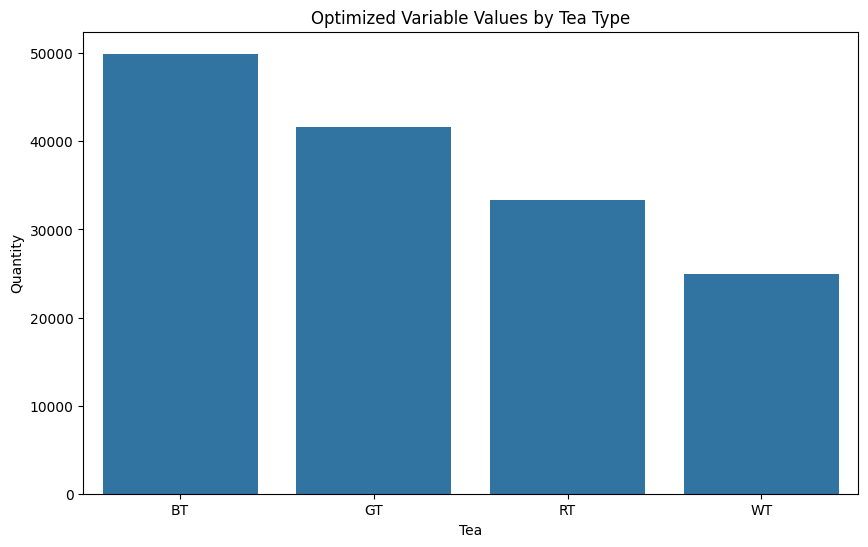

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Tea', y='Value', data=df, errorbar=None)
plt.title('Optimized Variable Values by Tea Type')
plt.ylabel('Quantity')
plt.show()


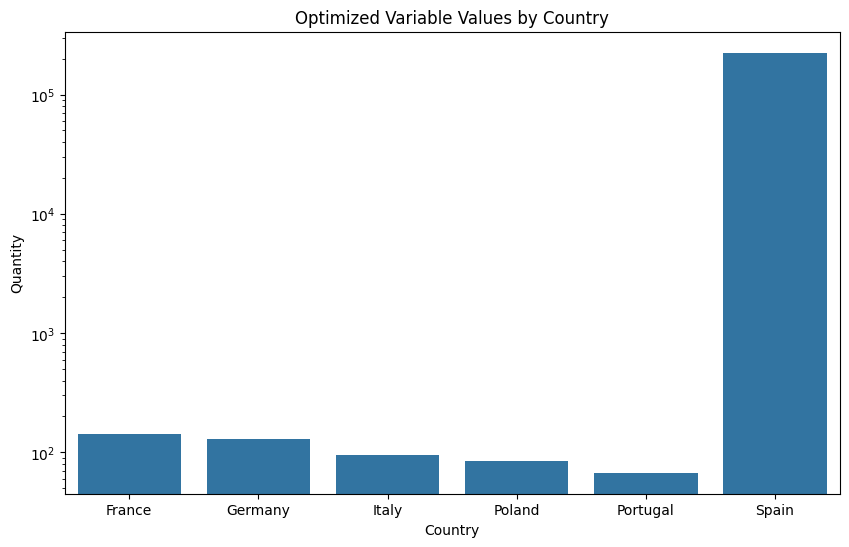

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Value', data=df, errorbar=None)
plt.title('Optimized Variable Values by Country')
plt.ylabel('Quantity')
plt.yscale('log')
plt.show()


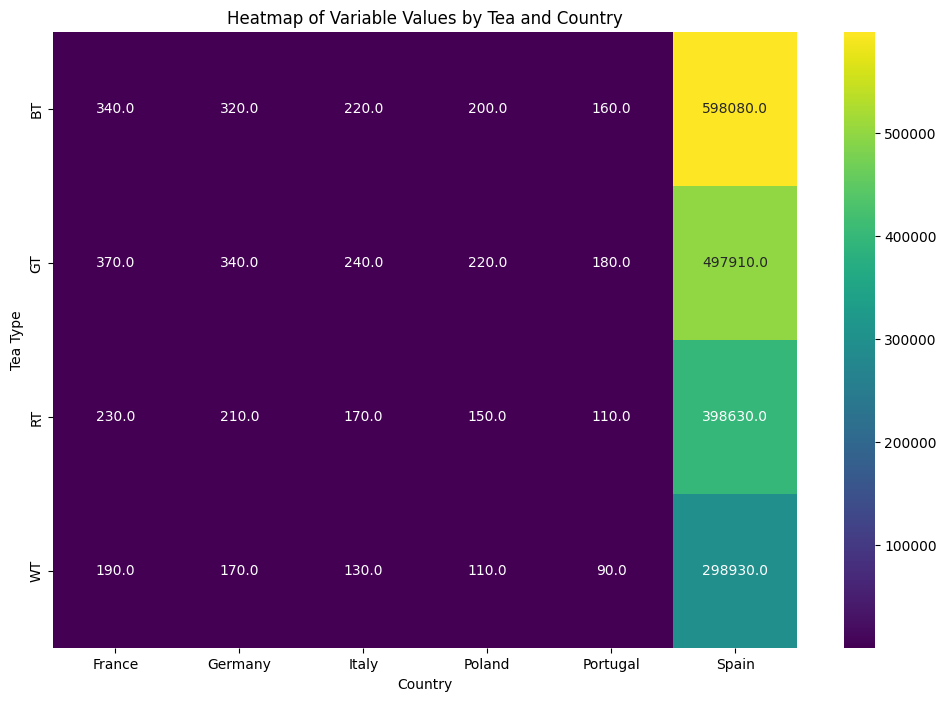

In [14]:
pivot_table = df.pivot_table(values='Value', index='Tea', columns='Country', aggfunc='sum', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='viridis')
plt.title('Heatmap of Variable Values by Tea and Country')
plt.ylabel('Tea Type')
plt.xlabel('Country')
plt.show()

#this graph proves statement above that we fulfill the demand and the rest goes to one country

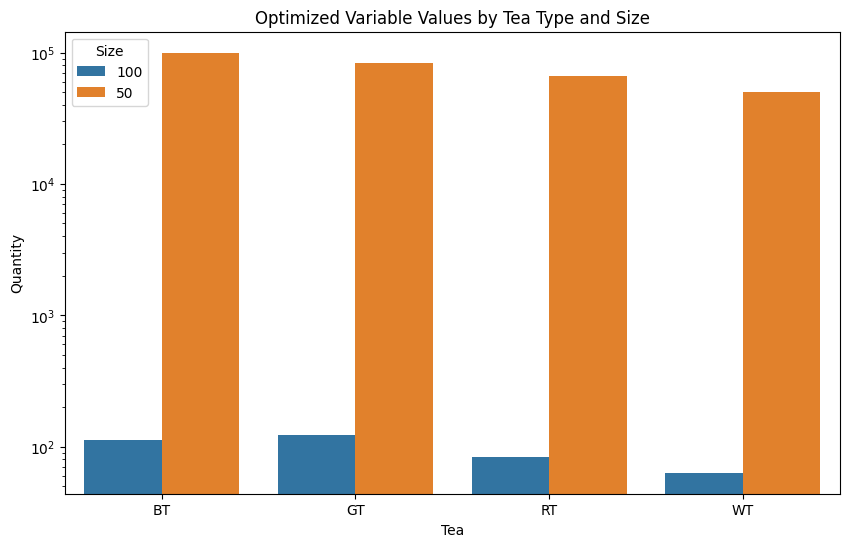

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Tea', y='Value', hue='Size', data=df, errorbar=None)
plt.title('Optimized Variable Values by Tea Type and Size')
plt.ylabel('Quantity')
plt.legend(title='Size')
plt.yscale('log')
plt.show()


## Exercise 2

In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, t
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
world_happiness = pd.read_csv('world_happiness.csv', index_col=0)

world_happiness.head()

,country,social_support,freedom,corruption,generosity,gdp_per_cap,life_exp,happiness_score
1,Finland,2.0,5.0,4.0,47.0,42400,81.8,155
2,Denmark,4.0,6.0,3.0,22.0,48300,81.0,154
3,Norway,3.0,3.0,8.0,11.0,66300,82.6,153
4,Iceland,1.0,7.0,45.0,3.0,47900,83.0,152
5,Netherlands,15.0,19.0,12.0,7.0,50500,81.8,151


In [17]:
mean_happiness = world_happiness['happiness_score'].mean()
median_happiness = world_happiness['happiness_score'].median()
standard_deviation_happiness = world_happiness['happiness_score'].std()

In [18]:
print(f"Mean happiness score: {mean_happiness} \nMedian happiness score: {median_happiness} \nStandard deviation of happiness score: {standard_deviation_happiness}")

Mean happiness score: 77.64335664335664 
Median happiness score: 79.0 
Standard deviation of happiness score: 46.37741764616525


In [19]:
top_5_by_gdp_per_capita = world_happiness.sort_values(by='gdp_per_cap', ascending=False).head(5)
top_5_by_gdp_per_capita[['country', 'happiness_score']]


,country,happiness_score
28,Qatar,127
14,Luxembourg,142
33,Singapore,122
16,Ireland,140
3,Norway,153


Text(0, 0.5, 'Happiness Score')

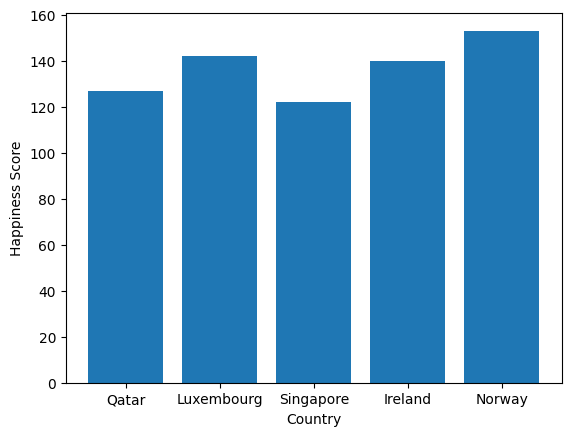

In [20]:
plt.bar(top_5_by_gdp_per_capita['country'], top_5_by_gdp_per_capita['happiness_score'])
plt.xlabel('Country')
plt.ylabel('Happiness Score')

<Axes: >

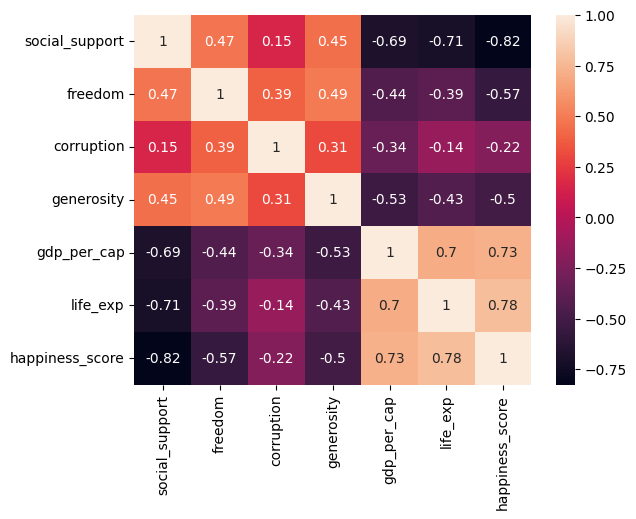

In [21]:
corr_dataset = world_happiness.drop(columns=['country'])
correlation_matrix = corr_dataset.corr()
sns.heatmap(correlation_matrix, annot=True)

array([[<Axes: title={'center': 'life_exp'}>]], dtype=object)

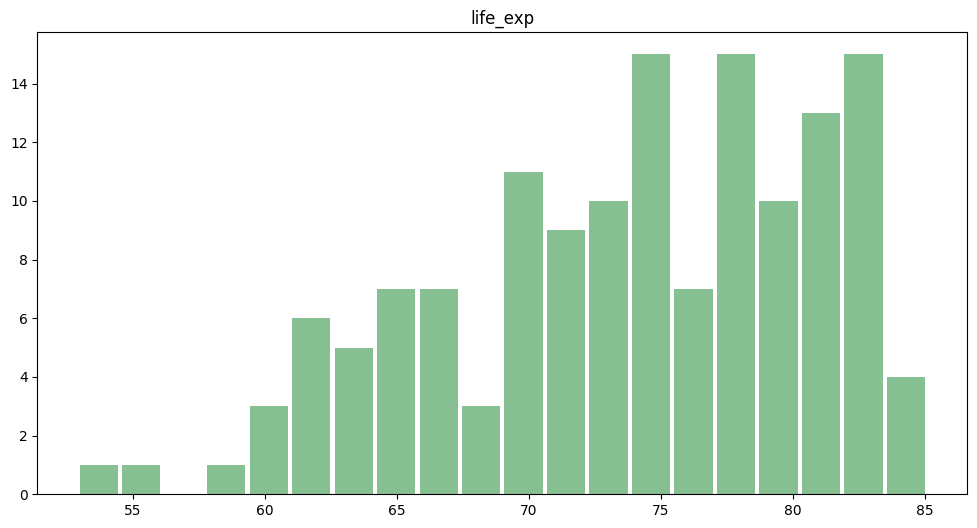

In [22]:
world_happiness.hist(column='life_exp', bins=20, grid=False, figsize=(12,6), color='#86bf91', zorder=2, rwidth=0.9)

We can see on the picture above that it's a left skewed distribution.  If it comes to the spread of the distribution one can notice that it's between more or less 53 up to 85. As we think about it, for Europeans it's quite a large spread. 

In [23]:
number_of_countries_with_social_support_larger_than_50 = world_happiness[world_happiness['social_support'] > 50]
probability = number_of_countries_with_social_support_larger_than_50.shape[0] / world_happiness.shape[0]
print(f"Probability of a country having a social support score larger than 50: {probability}")

Probability of a country having a social support score larger than 50: 0.6643356643356644


In [24]:
from scipy.stats import norm

mean_life_exp = world_happiness['life_exp'].mean()
std_life_exp = world_happiness['life_exp'].std()
#cdf - cumulative distribution function, hence probability of life expectancy being less than 80
# to find the probability of life expectancy being greater than 80, we subtract the cdf from 1
probability_life_exp_greater_than_80 = 1 - norm.cdf(80, mean_life_exp, std_life_exp)
print(f"Probability of a country having a life expectancy greater than 80: {probability_life_exp_greater_than_80}")

Probability of a country having a life expectancy greater than 80: 0.1908703229127775


In [25]:
X = world_happiness[['gdp_per_cap']]
y = world_happiness['happiness_score']

reg = LinearRegression()
reg.fit(X, y)

predicted_happiness = reg.predict(X)
world_happiness['predicted_happiness'] = predicted_happiness

#analyzing the predictions
mse = mean_squared_error(y, predicted_happiness)
mae = mean_absolute_error(y, predicted_happiness)
medae = median_absolute_error(y, predicted_happiness)
r2 = r2_score(y, predicted_happiness)

print(f"Mean Squared Error: {mse} \nMean Absolute Error: {mae} \nMedian Absolute Error: {medae} \nR^2 Score: {r2}")


Mean Squared Error: 1003.9544100372476 
Mean Absolute Error: 25.658480430998146 
Median Absolute Error: 23.470047185954783 
R^2 Score: 0.5299451272924903


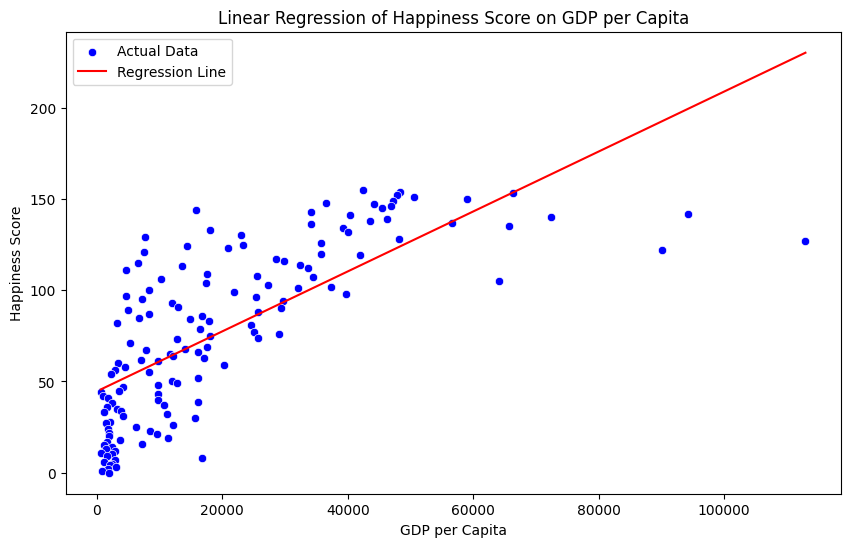

In [26]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='gdp_per_cap', y='happiness_score', data=world_happiness, label='Actual Data', color='blue')
sns.lineplot(x='gdp_per_cap', y='predicted_happiness', data=world_happiness, color='red', label='Regression Line')

plt.xlabel('GDP per Capita')
plt.ylabel('Happiness Score')
plt.title('Linear Regression of Happiness Score on GDP per Capita')
plt.legend()

plt.show()

Out of curiosity check out those 3 countries with largest gdp per capita countries that don't quite fit with the line 

In [27]:
world_happiness.sort_values(by='gdp_per_cap', ascending=False).head(3)


,country,social_support,freedom,corruption,generosity,gdp_per_cap,life_exp,happiness_score,predicted_happiness
28,Qatar,NaN,NaN,NaN,NaN,113000,80.5,127,230.076121
14,Luxembourg,27.0,28.0,9.0,30.0,94300,82.0,142,199.384645
33,Singapore,36.0,20.0,1.0,21.0,90100,85.1,122,192.491372


It might be weird for us, as we notice that Luxembourg and Singapore are well developed countries with quite good social_support, freedom and excellent corruption rates, gdp_per_capita and life expectancy, but somehow they are not happy. 

## HYPOTHESIS TESTING
Is there a significant difference in life_exp between countries with social_support above and below the median?
As we have two independent groups we will go with Two-Sample Testing. 

Null Hypothesis(H0): There is no significant difference in life expectancy between countries with social support above the median and those below the median.

Alternative Hypothesis(H1): There is a significant difference in life expectancy between countries with social support above the median and those below the median. 


In [ ]:

#I don't know if I had to describe steps as I simply followed the instructions from the presentation but I did it anyway and didn't do so for some easy stuff above 
#like calculating meand median, linear regression etc.
# Calculate median of social support to split the data into two groups
median_social_support = world_happiness['social_support'].median()

# Split the data
group_above_median = world_happiness[world_happiness['social_support'] > median_social_support]['life_exp']
group_below_median = world_happiness[world_happiness['social_support'] <= median_social_support]['life_exp']

# Calculate mean, standard deviation and sample size for each group
mean_above_median = group_above_median.mean()
std_above_median = group_above_median.std()
n_above_median = group_above_median.shape[0]

mean_below_median = group_below_median.mean()
std_below_median = group_below_median.std()
n_below_median = group_below_median.shape[0]

print(f"Group above median: mean={mean_above_median:.2f}, std={std_above_median:.2f}, n={n_above_median}")
print(f"Group below median: mean={mean_below_median:.2f}, std={std_below_median:.2f}, n={n_below_median}")

# Calculate the t-statistic
numerator = mean_above_median - mean_below_median
denominator = np.sqrt((std_above_median**2 / n_above_median) + (std_below_median**2 / n_below_median))
t_stat = numerator / denominator

print(f"t-statistic: {t_stat:.2f}")

# Calculate the two-tailed p-value
degrees_of_freedom = n_above_median + n_below_median - 2
p_value = 2 * (1 - t.cdf(abs(t_stat), df=degrees_of_freedom))
print(f"p-value: {p_value}")

#however, we can also use the ttest_ind function from scipy.stats to perform the t-test and the p-value is different due to precision and floating point arithmetic but doesn't change the conclusion
t_stat, p_value = ttest_ind(group_above_median, group_below_median, equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

alpha = 0.05 
if p_value < alpha:
    print("There is a significant difference in life expectancy between the two groups.")
else:
    print("There is no significant difference in life expectancy between the two groups.")

Group above median: mean=69.52, std=6.73, n=71
Group below median: mean=77.98, std=4.45, n=71
t-statistic: -8.83
p-value: 3.774758283725532e-15
T-statistic: -8.83421588857569
P-value: 9.373678715757926e-15
There is a significant difference in life expectancy between the two groups.


We can check it quickly using scatter plot and we can see that the left side of the graph with good social support (the values are reversed hence lower is better), have significantly better life expectancy. We could actually see it above when shown median of life exp of those two groups and 9 years difference is definitely large. 

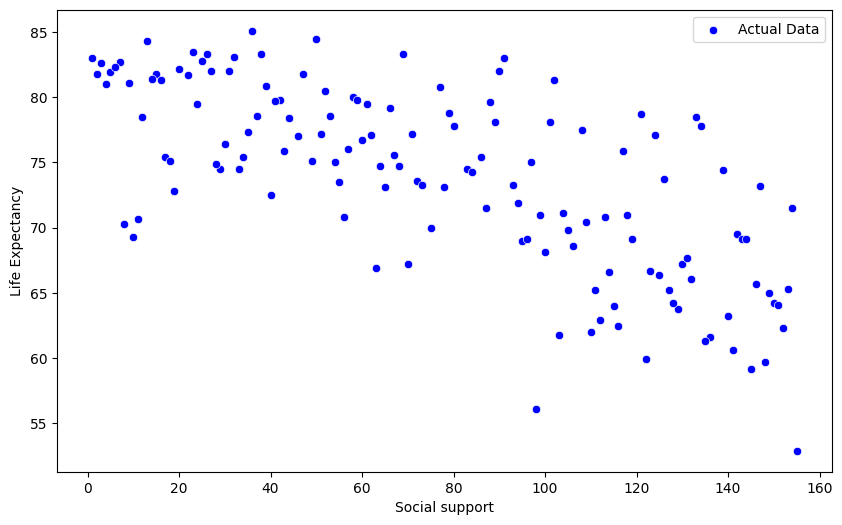

In [29]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='social_support', y='life_exp', data=world_happiness, label='Actual Data', color='blue')

plt.xlabel('Social support')
plt.ylabel('Life Expectancy')
plt.legend()

plt.show()